### Importing utilities:

In [27]:
# %matplotlib inline
%reload_ext autoreload
%autoreload 2

In [1]:
import os
from pathlib import Path
import skimage.external.tifffile as tiff

from common import Statistics, dataset_source
from resources.conv_learner import *
from resources.plots import *
from pprint import pprint
import matplotlib.pyplot as plt
%matplotlib inline

#### Setting up variables

In [2]:
PATH = "datasets/MNIST/"
data_path = Path(PATH)

In [3]:
NUM_CLASSES = 10
bs = 64
sz = 28

#### Calculating normalization statistics


In [4]:
# calculated for all images in train (hence also for val since val comes from val_idxs, see below)
# would be good to automate stats calculation 

stats = A([0.1306604762738429, 0.1306604762738429, 0.1306604762738429],
         [0.3081078038564622, 0.3081078038564622, 0.3081078038564622])

In [5]:
# setting up a list of a random 20% of images in train as the validation set

lbl_csv = PATH + 'train/labels.csv'
n = len(list(open(lbl_csv))) -1
val_idxs = get_cv_idxs(n)

## Defining datasets:

In [6]:
def get_data(path, lbl_csv, val_idxs, sz, bs, stats, aug_tfms):
    
    tfms = tfms_from_stats(stats, sz, aug_tfms=aug_tfms, crop_type = CropType.NO)
    data = ImageClassifierData.from_csv(PATH, 'train', lbl_csv, val_idxs = val_idxs,tfms=tfms, bs=bs)
    
    return data

In [7]:
data = get_data(PATH, lbl_csv, val_idxs, sz, bs, stats, aug_tfms = None)

### loading and inspecting images 

In [ ]:
x, y = next(iter(data.trn_dl))

In [ ]:
# show image by index 
idx = 9

im  = to_np(x)[idx]
im = np.moveaxis(im, 0, -1) # re-ordering (w,h,c)
plt.imshow(im)
print(f"label: {to_np(y)[idx]}")

In [ ]:
print(len(data.val_dl.dataset.y))
print(len(data.trn_dl.dataset.y))
# print(len(data.test_dl.dataset.y))

In [ ]:
# print transformations

idx = 0 
fig, ax = plt.subplots(2,4, figsize=(16,10))
for i, ax in enumerate(ax.flat):
    x, y = next(iter(data.aug_dl))
    im = to_np(x)[idx]
    ax.imshow(np.sum(im, axis = 0))

# Define Model

In [8]:
arch = resnet34

In [9]:
# using precompute = True results in some error during learn.fit() - not sure why...
learn = ConvLearner.pretrained(arch, data, precompute=False, ps=0.5)

In [ ]:
learn.summary()

In [ ]:
# learning rate finder
learn.lr_find()\
learn.sched.plot()

In [ ]:
# training only the last layers 
learn.fit(1e-2, 3, cycle_len=4, use_clr=(20,8, 0.95, 0.85))

In [ ]:
# unfreezing layers and using differential learning rates for first, second and third parts of the model
learn.unfreeze()
lrs = np.array([1e-8,1e-4,1e-2])

In [ ]:
learn.fit(lrs, 1, cycle_len=4)

In [ ]:
# call to plot traning progress

f = plt.figure()
x = learn.sched.plot_loss()
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.show()

In [ ]:
# saving/loading saved model

In [ ]:
learn.save('MNIST_unfrz_Resnet34_96')

In [10]:
learn.load('MNIST_unfrz_Resnet34_96')

In [11]:
learn.warm_up(1e-10)

EPOCH 0 ---------------------------------------- STEP 0                                                                                                                                                                                      
mean: [ 9.256   10.66667  9.244    9.65867  9.22267  8.49467  9.44533  9.83733  9.364    9.47867]
stdev: [3.67021 4.07704 3.58522 3.79168 3.68778 3.65248 3.88523 3.76513 3.86844 3.71899]

[3]: 94.36%
[7]: 95.1%
[9]: 92.07%
[0]: 97.55%
[2]: 95.31%
[6]: 98.41%
[4]: 96.54%
[8]: 95.28%
[1]: 98.4%
[5]: 95.27%
epoch      trn_loss   val_loss   accuracy   
    0      0.143371   0.134453   0.958663  



[array([0.13445]), 0.9586632218606492]

# Embeddings

In [12]:
# function to be called by register_forward_hook

def get_smth(layer, inp, outp):
    
    in_dim = outp.data.shape[0]
    tmp = torch.zeros(in_dim,512)
    tmp.copy_(outp.data)
    embeddings.append(tmp)

In [13]:
# getting a target layer module:
layer = learn.models.model._modules.get('12')

# registering the hook
hook = layer.register_forward_hook(get_smth)

# running learn.predict and collecting all activations from the target layer
embeddings = []
log_preds, y = learn.predict_with_targs()

hook.remove()

val


In [ ]:
# run this in case the previous cell resulted in an error. 
# If hooks are not removed before running again, requires kernel restart (?)
hook.remove()

In [42]:
print(embeddings[0].shape)

torch.Size([64, 512])


In [14]:
# stacking arrays from each batch on top of oneanother

embs = np.vstack(to_np(embeddings))
print(embs.shape)

(11999, 512)


# PCA and TSNE visualizations

In [15]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [16]:
# running PCA on embeddings
n_components = 100
pca = PCA(n_components)
pca_result = pca.fit_transform(embs)

Text(0.5, 1.0, 'Component-wise and Cumulative Explained Variance')

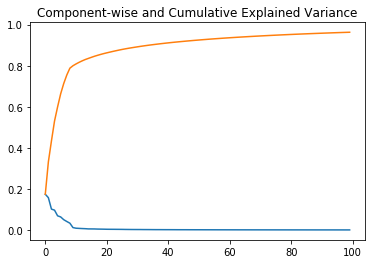

In [26]:
#plotting compenent-wise cumulative explained variance (for PCA)

plt.plot(range(n_components), pca.explained_variance_ratio_)
plt.plot(range(n_components), np.cumsum(pca.explained_variance_ratio_))
plt.title("Component-wise and Cumulative Explained Variance")

In [17]:
# running TSNE on embeddings

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(embs)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 11999 samples in 0.760s...
[t-SNE] Computed neighbors for 11999 samples in 160.362s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11999
[t-SNE] Computed conditional probabilities for sample 2000 / 11999
[t-SNE] Computed conditional probabilities for sample 3000 / 11999
[t-SNE] Computed conditional probabilities for sample 4000 / 11999
[t-SNE] Computed conditional probabilities for sample 5000 / 11999
[t-SNE] Computed conditional probabilities for sample 6000 / 11999
[t-SNE] Computed conditional probabilities for sample 7000 / 11999
[t-SNE] Computed conditional probabilities for sample 8000 / 11999
[t-SNE] Computed conditional probabilities for sample 9000 / 11999
[t-SNE] Computed conditional probabilities for sample 10000 / 11999
[t-SNE] Computed conditional probabilities for sample 11000 / 11999
[t-SNE] Computed conditional probabilities for sample 11999 / 11999
[t-SNE] Mean sigma: 5.432849
[t-SNE] KL diverge

<IPython.core.display.Javascript object>


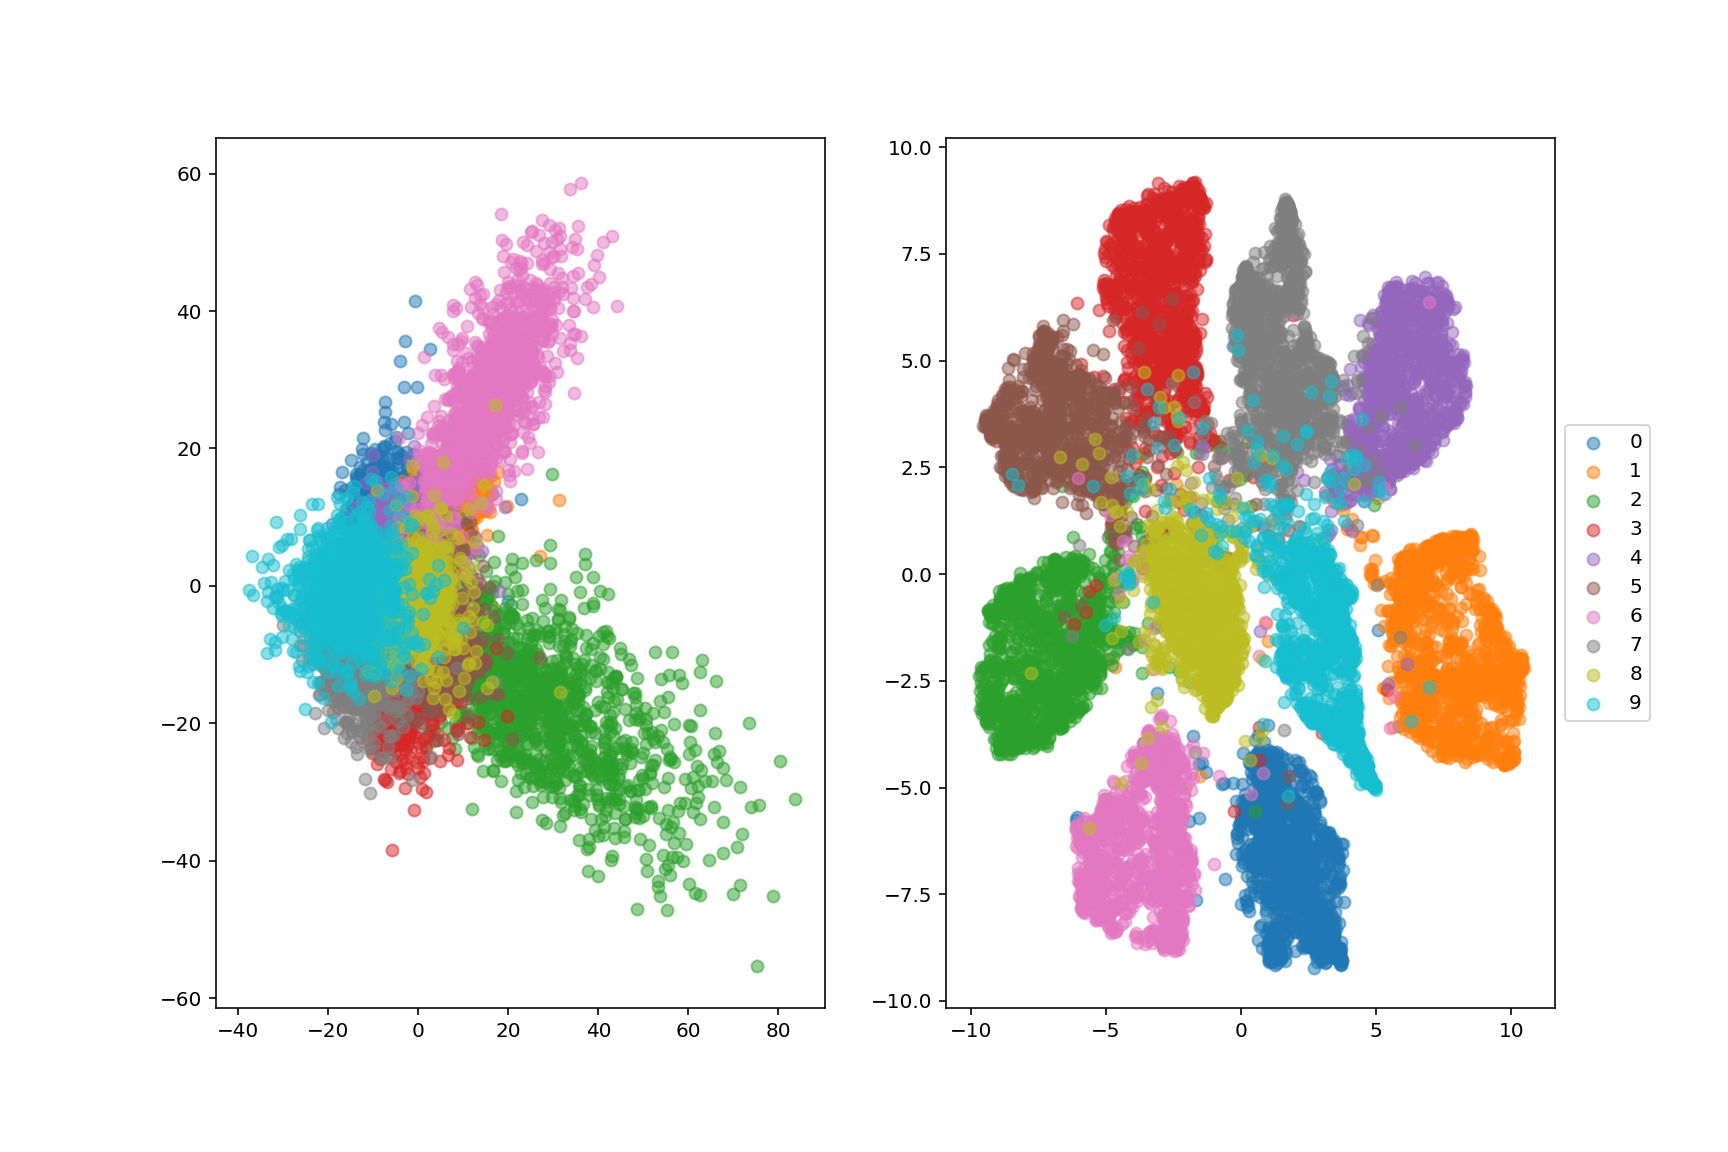

In [27]:
# plotting PCA vs TSNE results

fig, axarr = plt.subplots(1, 2, figsize=(12, 8))

compA = 0
compB = 1

for i in range(10):
    PCA_cls = pca_result[y == i]
    TSNE_cls = tsne_results[y == i]
    
    axarr[0].scatter(PCA_cls[:,compA], PCA_cls[:,compB], label = i, alpha = 0.5)
    axarr[1].scatter(TSNE_cls[:,compA], TSNE_cls[:,compB], label = i, alpha = 0.5)
    axarr[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [ ]:
# Running TSNE on the PCA components for better visualization

PCA_to_TSNE = TSNE(n_components=2, verbose=1, perplexity=100, n_iter=300)
PCA2_to_TSNE_results = PCA_to_TSNE.fit_transform(pca_result)

In [ ]:
# Plotting straight TSNE vs PCA-followed-by-TSNE

fig, axarr = plt.subplots(1, 2, figsize=(12, 8))

compA = 0
compB = 1

for i in range(10):
    TSNE_cls = tsne_results[y == i]
    PCA2TSNE_cls = PCA2_to_TSNE_results[y == i]
    
    axarr[0].scatter(TSNE_cls[:,compA], TSNE_cls[:,compB], alpha=0.5, label=i)
    axarr[1].scatter(PCA2TSNE_cls[:,compA], PCA2TSNE_cls[:,compB], alpha=0.5, label=i)
    axarr[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [ ]:
# plot large figure of TSNE(PCA(embeddings))

plt.style.use('seaborn-white')
fig, axarr = plt.subplots(1, 1, figsize=(12, 12))
plt.title('PCA-to-TSNE of feature embeddings')

compA = 0
compB = 1
for i in range(10):
    PCA2TSNE_cls = PCA2_to_TSNE_results[y == i]
    axarr.scatter(PCA2TSNE_cls[:,compA], PCA2TSNE_cls[:,compB], alpha=0.5, label=i)
    axarr.legend()

In [22]:
# Generate 3D TSNE space from PCA of embeddings

tsne3D = TSNE(n_components=3, verbose=1, perplexity=100, n_iter=300)
PCA2tSNE_results_3D = tsne3D.fit_transform(pca_result)

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 11999 samples in 0.103s...
[t-SNE] Computed neighbors for 11999 samples in 18.568s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11999
[t-SNE] Computed conditional probabilities for sample 2000 / 11999
[t-SNE] Computed conditional probabilities for sample 3000 / 11999
[t-SNE] Computed conditional probabilities for sample 4000 / 11999
[t-SNE] Computed conditional probabilities for sample 5000 / 11999
[t-SNE] Computed conditional probabilities for sample 6000 / 11999
[t-SNE] Computed conditional probabilities for sample 7000 / 11999
[t-SNE] Computed conditional probabilities for sample 8000 / 11999
[t-SNE] Computed conditional probabilities for sample 9000 / 11999
[t-SNE] Computed conditional probabilities for sample 10000 / 11999
[t-SNE] Computed conditional probabilities for sample 11000 / 11999
[t-SNE] Computed conditional probabilities for sample 11999 / 11999
[t-SNE] Mean sigma: 5.989184
[t-SNE] KL divergen

In [25]:
from mpl_toolkits import mplot3d

# magic command to make plots interactive.
# restart kernel if you want to switch to e.g. %matplotlib inline

%matplotlib notebook

<IPython.core.display.Javascript object>


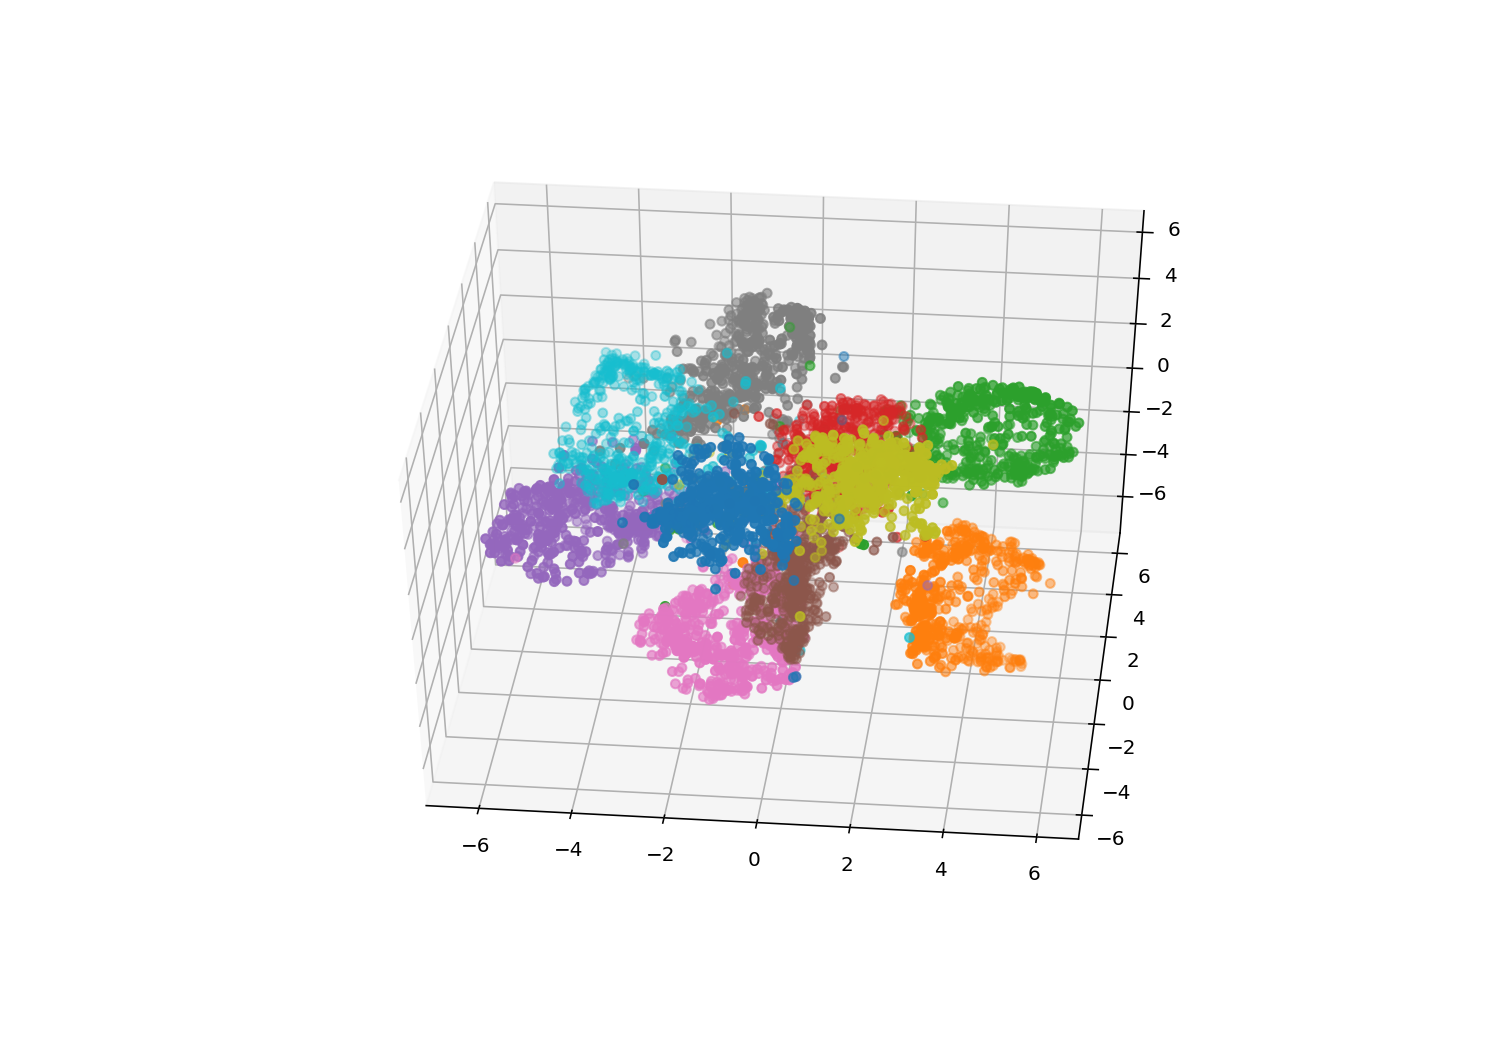

In [26]:
# 3D plotting - very slow interactivity atm...

fig = plt.figure()
ax = plt.axes(projection='3d')

compA = 0
compB = 1
compC = 2

for i in range(10):
    clss = PCA2tSNE_results_3D[y == i]
    cls_C = clss[0:500,:]
    ax.scatter3D(cls_C[:,compA], cls_C[:,compB], cls_C[:,compC])

# Predictions

In [31]:
log_preds, y = learn.TTA(n_aug=1) # run predictions with TTA

<IPython.core.display.Javascript object>


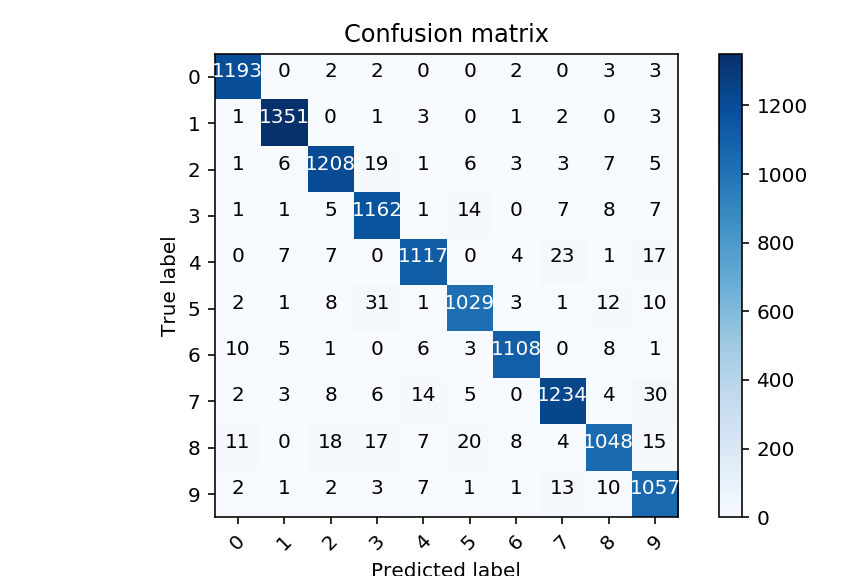

[[1193    0    2    2    0    0    2    0    3    3]
 [   1 1351    0    1    3    0    1    2    0    3]
 [   1    6 1208   19    1    6    3    3    7    5]
 [   1    1    5 1162    1   14    0    7    8    7]
 [   0    7    7    0 1117    0    4   23    1   17]
 [   2    1    8   31    1 1029    3    1   12   10]
 [  10    5    1    0    6    3 1108    0    8    1]
 [   2    3    8    6   14    5    0 1234    4   30]
 [  11    0   18   17    7   20    8    4 1048   15]
 [   2    1    2    3    7    1    1   13   10 1057]]


In [32]:
# Plot confusion matrix 
log_preds_mean = np.mean(log_preds, axis=0)
preds = np.argmax(log_preds_mean, axis=1)
cm = confusion_matrix(preds,y)
plot_confusion_matrix(cm, data.classes)